In [15]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from jax import vmap, value_and_grad
import optax
import jaxopt
import enlighten
import os
import scipy

from NNmodels import MLP, MLP_init_params, glorot_normal, MSE

In [16]:
# check for devices - if gpu available
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
devices = jax.local_devices()
print(devices)

[CudaDevice(id=0)]


In [17]:
# training config dict
tr_config = {
    "lr_0" : 0.001,              # Initial learning rate for the optimizer
    "lr_gamma": 0.95,            # Learning rate decay factor (multiplies the learning rate by this value at each step)
    "lr_step" : 1000,            # Number of iterations after which the learning rate is updated (decayed)
    "lr_f" : 1e-5,               # Final learning rate (smallest allowed learning rate after decay)
    "maxiter_adam" : 1000,       # Maximum number of iterations for the Adam optimizer
    "maxiter_lbfgs": 1000,       # Maximum number of iterations for the L-BFGS optimizer
    "deepOnet_width" : 50,       # Width of the hidden layers in the DeepONet model (number of neurons per layer)
    "trunk_architecture" : [50, 50, 50],  # Architecture of the trunk network, with 3 layers each containing 50 neurons
    "trunk_activation": jnp.tanh, # Activation function used in the trunk network (tanh in this case)
    "trunk_input_dim": 1,        # Input dimension for the trunk network
    "trunk_output_dim": 1,       # Output dimension for the trunk network
    "trunk_sensor": 100,         # Number of sensors (inputs) for the trunk network
    "num_train": 10,             # Number of training samples
    "num_test": 5                # Number of test samples
}


In [18]:
# Data preparation

# trk_sensor_pts: Sensor points for the trunk network
# Randomly generates points uniformly in the range [0, 1]
# Shape: (number of sensors, trunk input dimension)
trk_sensor_pts = np.random.uniform(0, 1, (tr_config['trunk_sensor'], tr_config['trunk_input_dim']))

# Loop through the number of training samples
for i in range(tr_config['num_train']):
    w = (i + 1) / tr_config['num_train']  # Weighting factor based on the current sample index

    if i == 0:
        # Initialize the target values for the first training sample
        # trk_targets: Sine values of the weighted sensor points (first target)
        # Shape: (number of sensors, trunk input dimension)
        trk_targets = np.sin(np.pi * w * trk_sensor_pts)
    else:
        # Concatenate the sine values for subsequent training samples along the second axis (column-wise)
        # Expands the targets matrix to include all training samples
        # Axis 1 means concatenate along columns
        trk_targets = np.concatenate([trk_targets, np.sin(np.pi * w * trk_sensor_pts)], axis=1)


In [19]:
# Initialize 'Trunk Network' and 'A'

# T_layers: Defines the architecture of the trunk network
# Starts with the input dimension, followed by the trunk architecture (hidden layers),
# and ends with the width of the DeepONet network.
T_layers = [tr_config["trunk_input_dim"]] + tr_config["trunk_architecture"] + [tr_config["deepOnet_width"]]

# T_act_fn: Activation function to be used in the trunk network (e.g., tanh in this case)
T_act_fn = tr_config["trunk_activation"]

# params_trk: Initializes the parameters of the trunk network (weights and biases) using MLP_init_params function
# The input to MLP_init_params is the network layer configuration defined in T_layers.
params_trk = MLP_init_params(T_layers)

# NN_trk: Assigns the model to be used for the trunk network, which is a multi-layer perceptron (MLP)
NN_trk = MLP

# params_A: Initializes the parameters for 'A', typically part of the DeepONet model
# Uses the Glorot Normal initialization to generate a matrix of shape (number of training samples, width of DeepONet + 1)
# These parameters are likely used to combine the outputs from the branch and trunk networks.
params_A = glorot_normal(tr_config['num_train'], tr_config['deepOnet_width'] + 1)

# params: Combines the parameters of the trunk network (params_trk) and 'A' (params_A) into a single tuple
# This tuple contains all the parameters needed for training the model.
params = params_trk, params_A


In [20]:
# Step 1 of DeepONet function definition
def DON_step1(params):
    # Unpack parameters into trunk network parameters and 'A' parameters
    params_trk, params_A = params

    # Return a lambda function representing the output of the DeepONet model
    # 1. NN_trk(params_trk, x, T_act_fn) applies the trunk network to the input 'x'
    #    and computes the trunk output using the specified activation function 'T_act_fn'.
    #    The output is reshaped to add an extra dimension to match the shape requirements.
    # 2. params_A[:,:-1] @ ... performs a matrix multiplication between 'A' (without the last column) and the trunk network output.
    # 3. params_A[:,-1][:,None] adds a bias term (the last column of 'A'), ensuring shape compatibility.
    # 4. [:,0] removes the extra dimension added earlier, returning the final output as a 1D array.
    return lambda x: (params_A[:,:-1] @ NN_trk(params_trk, x, T_act_fn)[:,None] + params_A[:,-1][:,None])[:,0]

# Loss function computation using JAX
@jax.jit
def loss_step1(params):
    # Generate the DeepONet function using the current parameters
    don_fn = DON_step1(params)

    # Compute the mean squared error (MSE) between the model's predictions and the target values
    # vmap applies the 'don_fn' to each row of 'trk_sensor_pts' in parallel
    return MSE(vmap(don_fn, (0))(trk_sensor_pts), trk_targets)

# Gradient computation setup
# value_and_grad returns both the loss value and its gradient with respect to the parameters
value_grad_fn = value_and_grad(loss_step1)


In [21]:
# Training configuration parameters
maxepochs  = tr_config["maxiter_adam"]  # Maximum number of epochs for training with Adam optimizer
lr0        = tr_config["lr_0"]          # Initial learning rate for Adam optimizer
decay_rate = tr_config["lr_gamma"]      # Learning rate decay factor
decay_step = tr_config["lr_step"]       # Number of steps after which the learning rate is decayed
lrf        = tr_config["lr_f"]          # Final learning rate (minimum after decay)

# Progress bar setup using enlighten for visual feedback during training
manager = enlighten.get_manager()  # Initialize the progress manager
outer_bar_format = u'{desc}{desc_pad}{percentage:3.0f}%|{bar}| ' + \
                 u'{count:{len_total}d}/{total:d} ' + \
                 u'[{elapsed}<{eta}, {rate:.2f}{unit_pad}{unit}/s] ' + \
                 u'{loss}{current_loss:1.4e}'  # Custom format for the progress bar, showing loss and time details
                 
# Create the progress bar for the outer loop (training epochs)
pbar_outer = manager.counter(
    total=maxepochs,               # Total number of epochs (training iterations)
    desc="Main Loop",              # Description of the progress bar
    unit="epochs",                 # Unit to track (epochs)
    color="red",                   # Color of the progress bar
    loss="loss=",                  # Prefix for displaying the loss value
    current_loss=1e+9,             # Initial high loss value for display
    bar_format=outer_bar_format    # Format defined above for the progress bar
)

# Optimizer setup using Optax (Adam optimizer with exponential learning rate decay)
# Learning rate decays over time with the given decay rate and final value
opt_adam = optax.adam(optax.exponential_decay(lr0, decay_step, decay_rate, end_value=lrf))

# Initialize the optimizer state using the parameters of the model
opt_state = opt_adam.init(params)

# Initialize lists to log loss values and minimum loss over epochs
log_loss  = []  # Track the loss value for each epoch
log_minloss = []  # Track the minimum loss value observed so far

# Main training loop for the specified number of epochs
for epoch in range(maxepochs):
    # Compute the loss value and its gradient with respect to the parameters
    lvalue, grads = value_grad_fn(params)
    
    # Update the optimizer state and compute parameter updates based on the gradients
    updates, opt_state = opt_adam.update(grads, opt_state)
    
    # Apply the computed updates to the model parameters
    params = optax.apply_updates(params, updates)
    
    # Update the progress bar with the current loss value
    pbar_outer.update(current_loss=lvalue)
    
    # For the first epoch, set the minimum loss value to the current loss
    if epoch == 0:
        minloss = lvalue
    
    # If the current loss is lower than the minimum loss observed so far, update the minimum loss and save the parameters
    if lvalue < minloss:
        minloss = lvalue
        params_opt = params  # Save the parameters that achieved the minimum loss
    
    # Log the current loss and minimum loss values
    log_loss.append(lvalue)
    log_minloss.append(minloss)

# Stop the progress bar once training is complete
manager.stop()


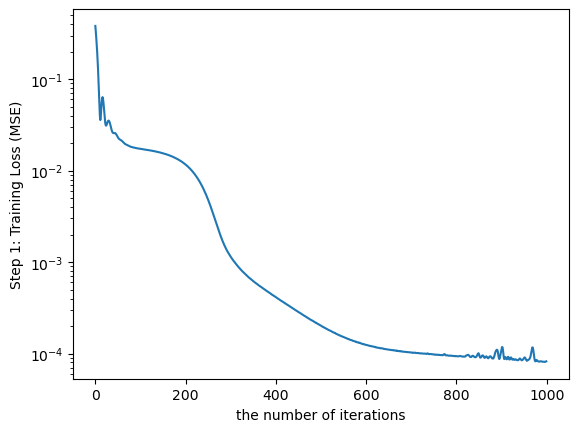

In [22]:
plt.figure()
plt.semilogy(log_loss)
plt.xlabel('the number of iterations')
plt.ylabel('Step 1: Training Loss (MSE)')
plt.show()

In [23]:
# L-BFGS optimizer configuration and run

# Initialize the L-BFGS optimizer using jaxopt
# Parameters:
# - fun: The function to minimize, in this case, 'loss_step1' which computes the loss.
# - value_and_grad=False: Indicates that we are only interested in the function value (not the gradient, as L-BFGS computes it internally).
# - maxiter: Maximum number of iterations for the L-BFGS optimization, set from the training config.
# - history_size: The number of previous iterations used to approximate the Hessian matrix for the optimizer.
# - verbose=True: Enables verbose output to display progress during optimization.
opt_lbfgs = jaxopt.LBFGS(
    fun=loss_step1, 
    value_and_grad=False, 
    maxiter=tr_config["maxiter_lbfgs"], 
    history_size=10, 
    verbose=True
)

# Run the L-BFGS optimization starting from the previously optimized parameters ('params_opt').
# The optimization process will attempt to further minimize the loss function.
res = opt_lbfgs.run(params_opt)

# Unpack the optimized parameters and the state of the optimizer after the run
params_opt, state = res


INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0004573978076223284 Stepsize:1.0  Decrease Error:0.00023012068413663656  Curvature Error:0.0004573978076223284 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 0.00021932479285169393 Stepsize:0.5  Decrease Error:5.6117147323675454e-05  Curvature Error:0.00021932479285169393 
INFO: jaxopt.ZoomLineSearch: Iter: 3 Minimum Decrease & Curvature Errors (stop. crit.): 9.660804062150419e-05 Stepsize:0.25  Decrease Error:1.2259476534381974e-05  Curvature Error:9.660804062150419e-05 
INFO: jaxopt.ZoomLineSearch: Iter: 4 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.02797587960958481  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.LBFGS: Iter: 1 Gradient Norm (stop. crit.): 0.0005411080783233047 Objective Value:8.10555720818229e-05  Stepsize:0.02797587960958481  Number Linesearch Iterations:4 


In [24]:
# Unpack the optimized parameters
params_trk, params_A = params_opt  # 'params_opt' contains the final optimized parameters for the trunk network and 'A'

# Compute the matrix for the trunk network
# vmap applies the NN_trk (trunk network) function to each row of 'trk_sensor_pts' in parallel
# This generates the output of the trunk network for all sensor points
# A column of ones is concatenated to this output to form the matrix 'trk_MAT1'
# Shape of 'trk_MAT1': (number of sensors, trunk network output + 1)
trk_MAT1 = np.concatenate(
    [vmap(lambda x: NN_trk(params_trk, x, T_act_fn), (0))(trk_sensor_pts),  # Apply trunk network to sensor points
     jnp.ones([tr_config["trunk_sensor"], 1])],  # Append a column of ones for bias
    axis=1  # Concatenate along the second axis (columns)
)

# Solve the least squares problem to find the updated 'A' parameters
# scipy.linalg.lstsq solves the equation trk_MAT1 @ params_A = trk_targets to minimize the squared error
# This finds the best-fitting 'params_A' such that the trunk network output matches the targets
params_A = scipy.linalg.lstsq(trk_MAT1, trk_targets)[0]  # Least squares solution

# Perform QR decomposition of the matrix 'trk_MAT1'
# This decomposes 'trk_MAT1' into an orthogonal matrix 'q_st' and an upper triangular matrix 'r_st'
q_st, r_st = scipy.linalg.qr(trk_MAT1, mode='economic')  # 'economic' mode returns the reduced form of the matrices

# Compute the target 'A_target' by multiplying 'r_st' with the least squares solution for 'params_A'
A_target = r_st @ params_A  # Target value for 'A' based on the QR decomposition


In [25]:
# save : params_trk, A_target (must save) | In Step 2, Branch should learn A_target
# save : trk_MAT1, params_A   (optional)

NameError: name 'trk_MAT1' is not defined